In [1]:
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import numpy as np
import nir
import norse
import tonic
import torch
import tqdm
import importlib
import lava_cnn_reader
importlib.reload(lava_cnn_reader);

In [2]:
plt.style.use(["science", "bright"])

In [3]:
graph = nir.read('cnn_sinabs.nir')
norse_graph = norse.torch.from_nir(graph)
children = list(norse_graph.children())
net = lava_cnn_reader.nir_to_lava_dl(graph)

In [5]:
print("NIR graph exported!")
for node_key, node in graph.nodes.items():
    print(f'\tnode {node_key}: {type(node).__name__}')
for edge in sorted(graph.edges):
    print('\tedge', edge)

NIR graph exported!
	node 0: Conv2d
	node 1: IF
	node 10: IF
	node 11: Affine
	node 12: IF
	node 2: Conv2d
	node 3: IF
	node 4: SumPool2d
	node 5: Conv2d
	node 6: IF
	node 7: SumPool2d
	node 8: Flatten
	node 9: Affine
	node input: Input
	node output: Output
	edge ('0', '1')
	edge ('1', '2')
	edge ('10', '11')
	edge ('11', '12')
	edge ('12', 'output')
	edge ('2', '3')
	edge ('3', '4')
	edge ('4', '5')
	edge ('5', '6')
	edge ('6', '7')
	edge ('7', '8')
	edge ('8', '9')
	edge ('9', '10')
	edge ('input', '0')


In [5]:
bs = 128
collate = tonic.collation.PadTensors(batch_first=False)
to_frame = tonic.transforms.ToFrame(sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3)
test_ds = tonic.datasets.NMNIST("./nmnist", transform=to_frame, train=False)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=bs, collate_fn=collate)

In [51]:
lens = [len(net.blocks), len(children)]
assert lens[0] == lens[1]

sample_idx = 9020
inp = test_ds[sample_idx][0]
lbl = test_ds[sample_idx][1]

lava_outputs = {}
lava_hidden = {}
norse_outputs = {}
norse_hidden = {}
for idx in range(lens[0]):
    lavablock = net.blocks[idx]
    norseblock = children[[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4][idx]]
    print(f'block {idx:02}: {type(lavablock).__name__:10} {type(norseblock).__name__:10}')

    if idx == 0:
        x_lava = torch.Tensor(inp).moveaxis(0, -1).unsqueeze(0)
        x_norse = torch.Tensor(inp)
        print('x_lava', x_lava.shape, 'x_norse', x_norse.shape)

    # lava forward pass
    x = lava_outputs[idx-1] if idx > 0 else x_lava
    if isinstance(lavablock, slayer.neuron.cuba.Neuron):
        lava_outputs[idx], lava_hidden[idx] = lavablock.forward(x, debug=True)
        assert torch.allclose(lava_outputs[idx].detach(), lavablock(x).detach())
    else:
        lava_outputs[idx] = lavablock(x)

    # norse forward pass
    x = norse_outputs[idx-1] if idx > 0 else x_norse
    if isinstance(norseblock, norse.torch.IAFCell):
        T = x.shape[0]
        outs = [None for _ in range(T)]
        vs = [None for _ in range(T)]
        for t in range(T):
            outs[t], vs[t] = norseblock(x[t], vs[t-1] if t > 0 else None)
        norse_outputs[idx] = torch.concat(outs, dim=0)
        norse_hidden[idx] = torch.concat([v.v for v in vs], dim=0)
    else:
        norse_outputs[idx] = norseblock(x)
    if isinstance(x, tuple):
        print(x)

    # print(f'block {idx:02}: {type(lavablock)} {type(norseblock)}')
    print('close:', torch.allclose(lava_outputs[idx].squeeze(0).moveaxis(-1, 0), norse_outputs[idx], atol=1e-5, rtol=1e-5))

block 00: Conv       Conv2d    
x_lava torch.Size([1, 2, 34, 34, 306]) x_norse torch.Size([306, 2, 34, 34])
close: True
block 01: Neuron     IAFCell   
close: True
block 02: Conv       Conv2d    
close: False
block 03: Neuron     IAFCell   
close: True
block 04: Pool       LPPool2d  
close: True
block 05: Conv       Conv2d    
close: False
block 06: Neuron     IAFCell   
close: True
block 07: Pool       LPPool2d  
close: True
block 08: Flatten    Flatten   
close: True
block 09: Dense      Linear    
close: True
block 10: Neuron     IAFCell   
close: True
block 11: Dense      Linear    
close: True
block 12: Neuron     IAFCell   
close: True


In [152]:
def normalize_to_0_1(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())


def plot_outputs(lava_outputs, norse_outputs, layer_idx=1):
    im_lava = lava_outputs[layer_idx].detach().numpy().mean(axis=-1)[0, ...]
    im_norse = norse_outputs[layer_idx].detach().numpy().mean(axis=0)
    fig, axs = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(8, 4), dpi=300)
    fig.suptitle(f'Normalized firing rate at layer {layer_idx} (I\&F neuron population)')
    for i in range(5):
        axs[0][i].set_title(f'Channel {i+1}')
        lava = normalize_to_0_1(im_lava[i])
        norse = normalize_to_0_1(im_norse[i])
        imax = axs[0][i].imshow(lava, vmin=0, vmax=1)
        axs[1][i].imshow(norse, vmin=0, vmax=1)
        axs[2][i].imshow(np.abs(lava - norse), vmin=0, vmax=1)
        for j in range(3):
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])
    axs[0][0].set_ylabel('Lava (CPU)')
    axs[1][0].set_ylabel('Norse')
    axs[2][0].set_ylabel('Difference')
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.975, 0.1, 0.02, 0.7])
    fig.colorbar(imax, cax=cbar_ax)
    plt.show();

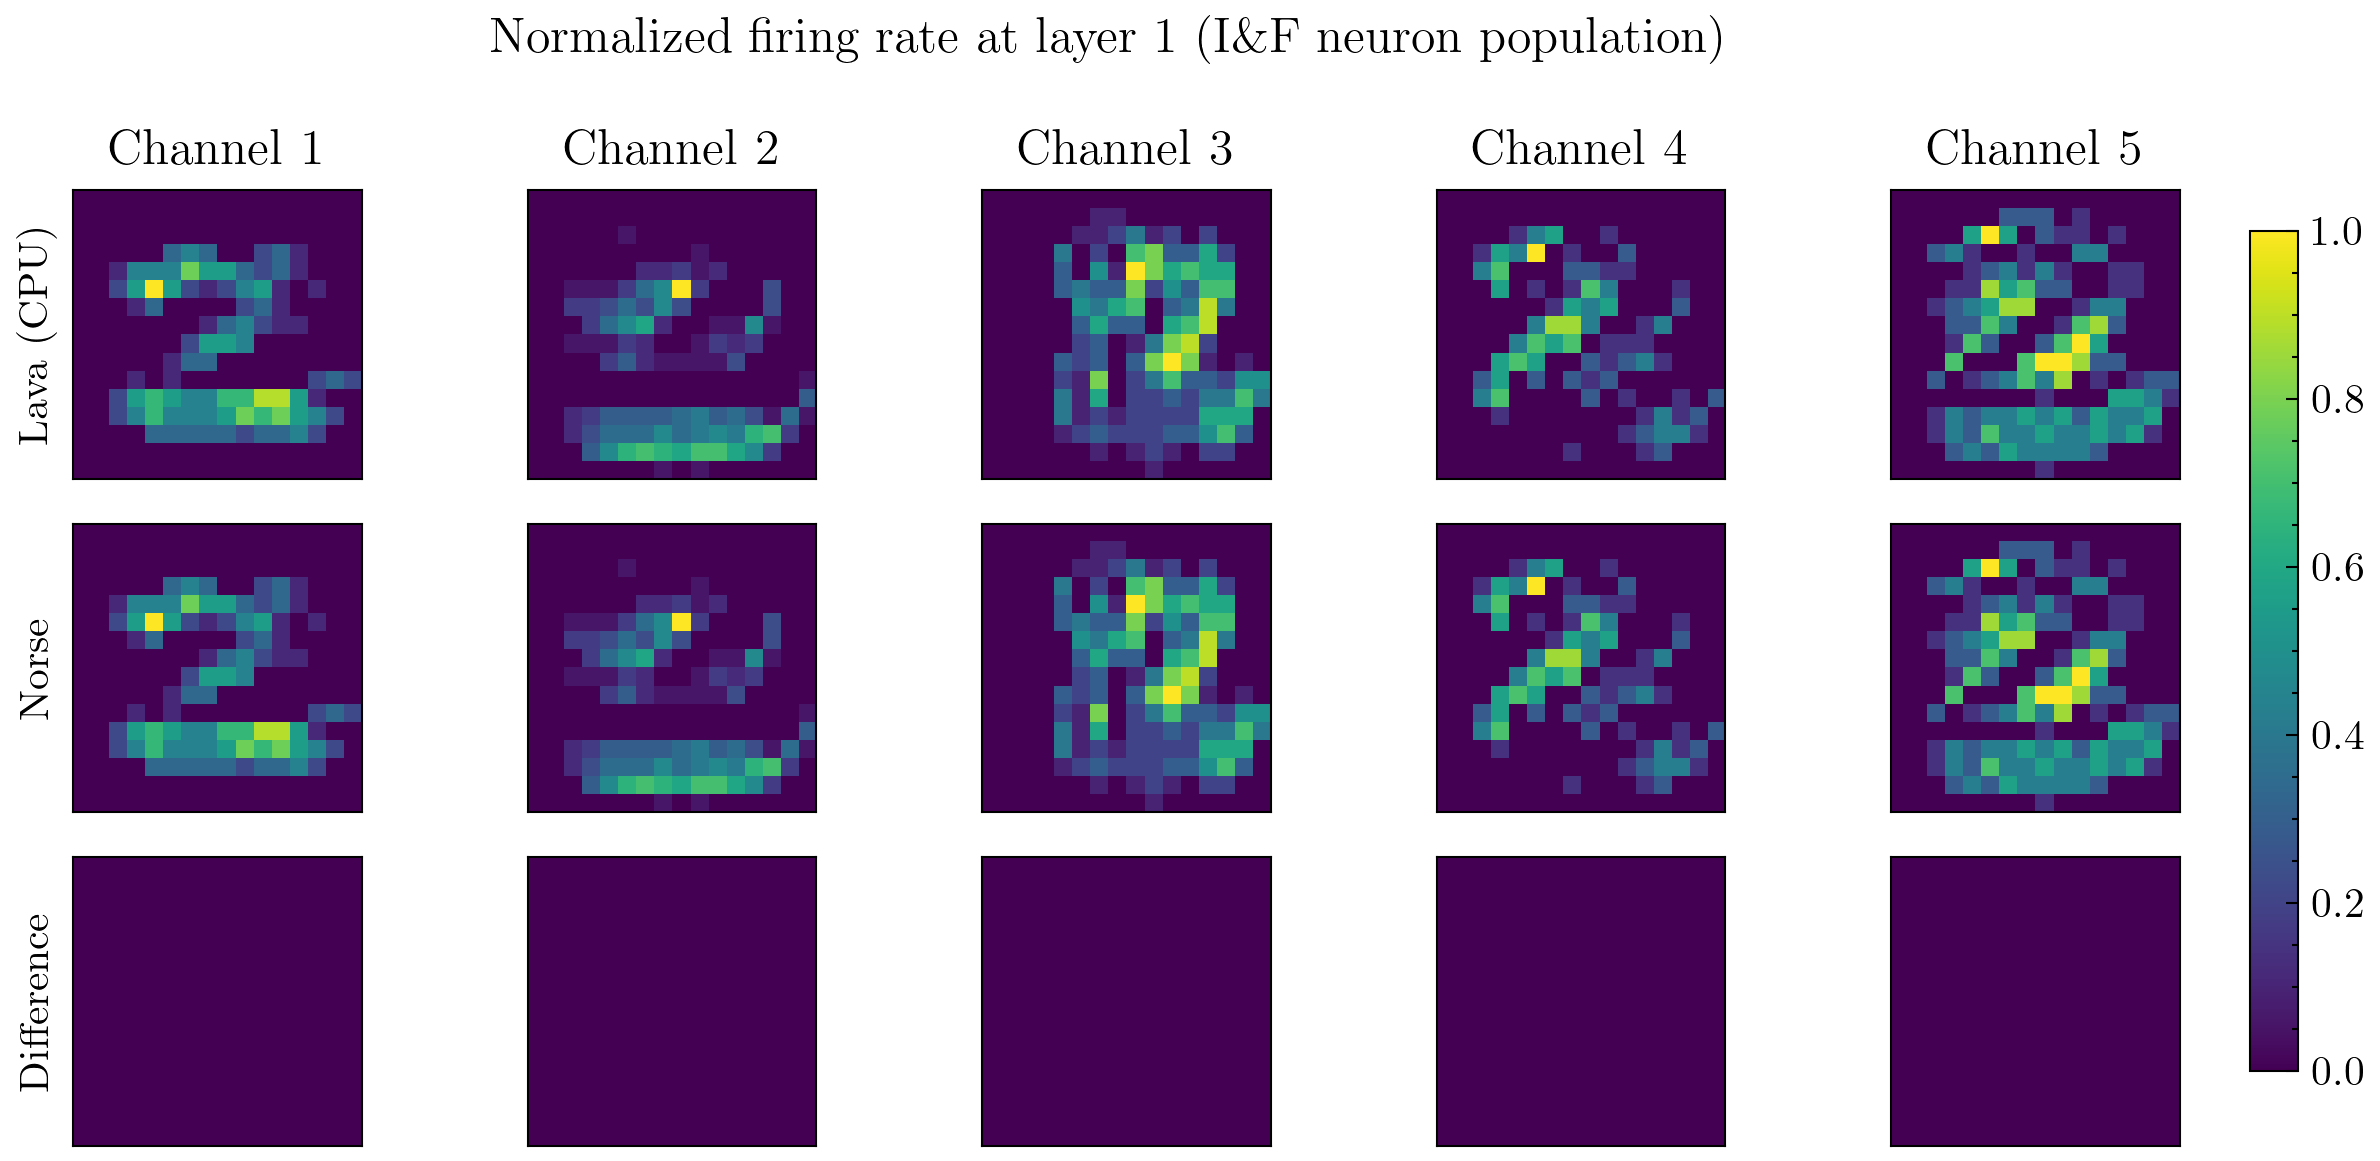

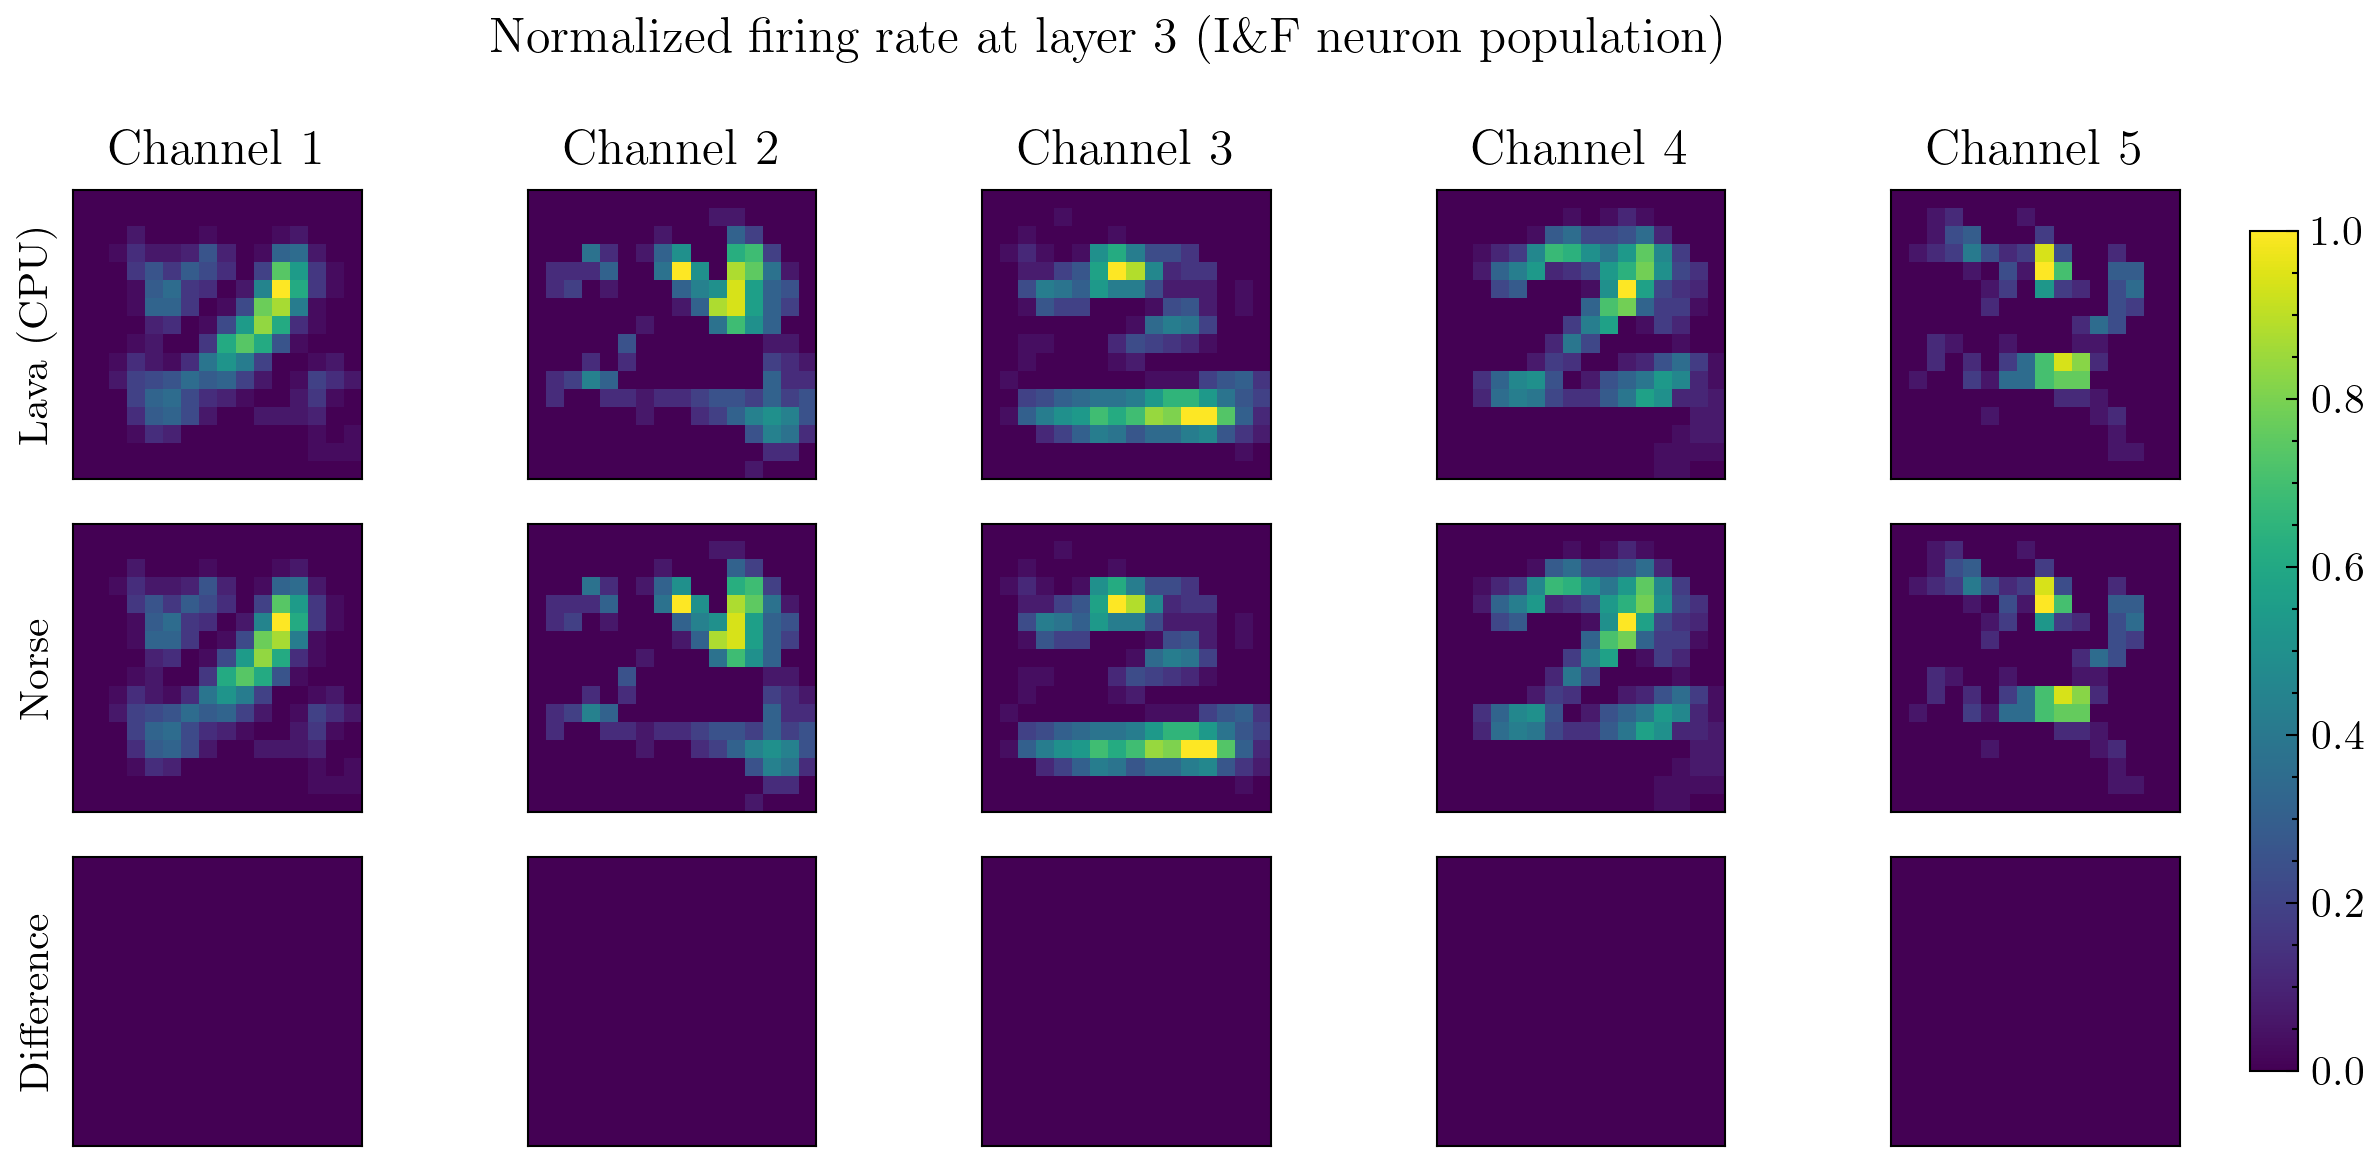

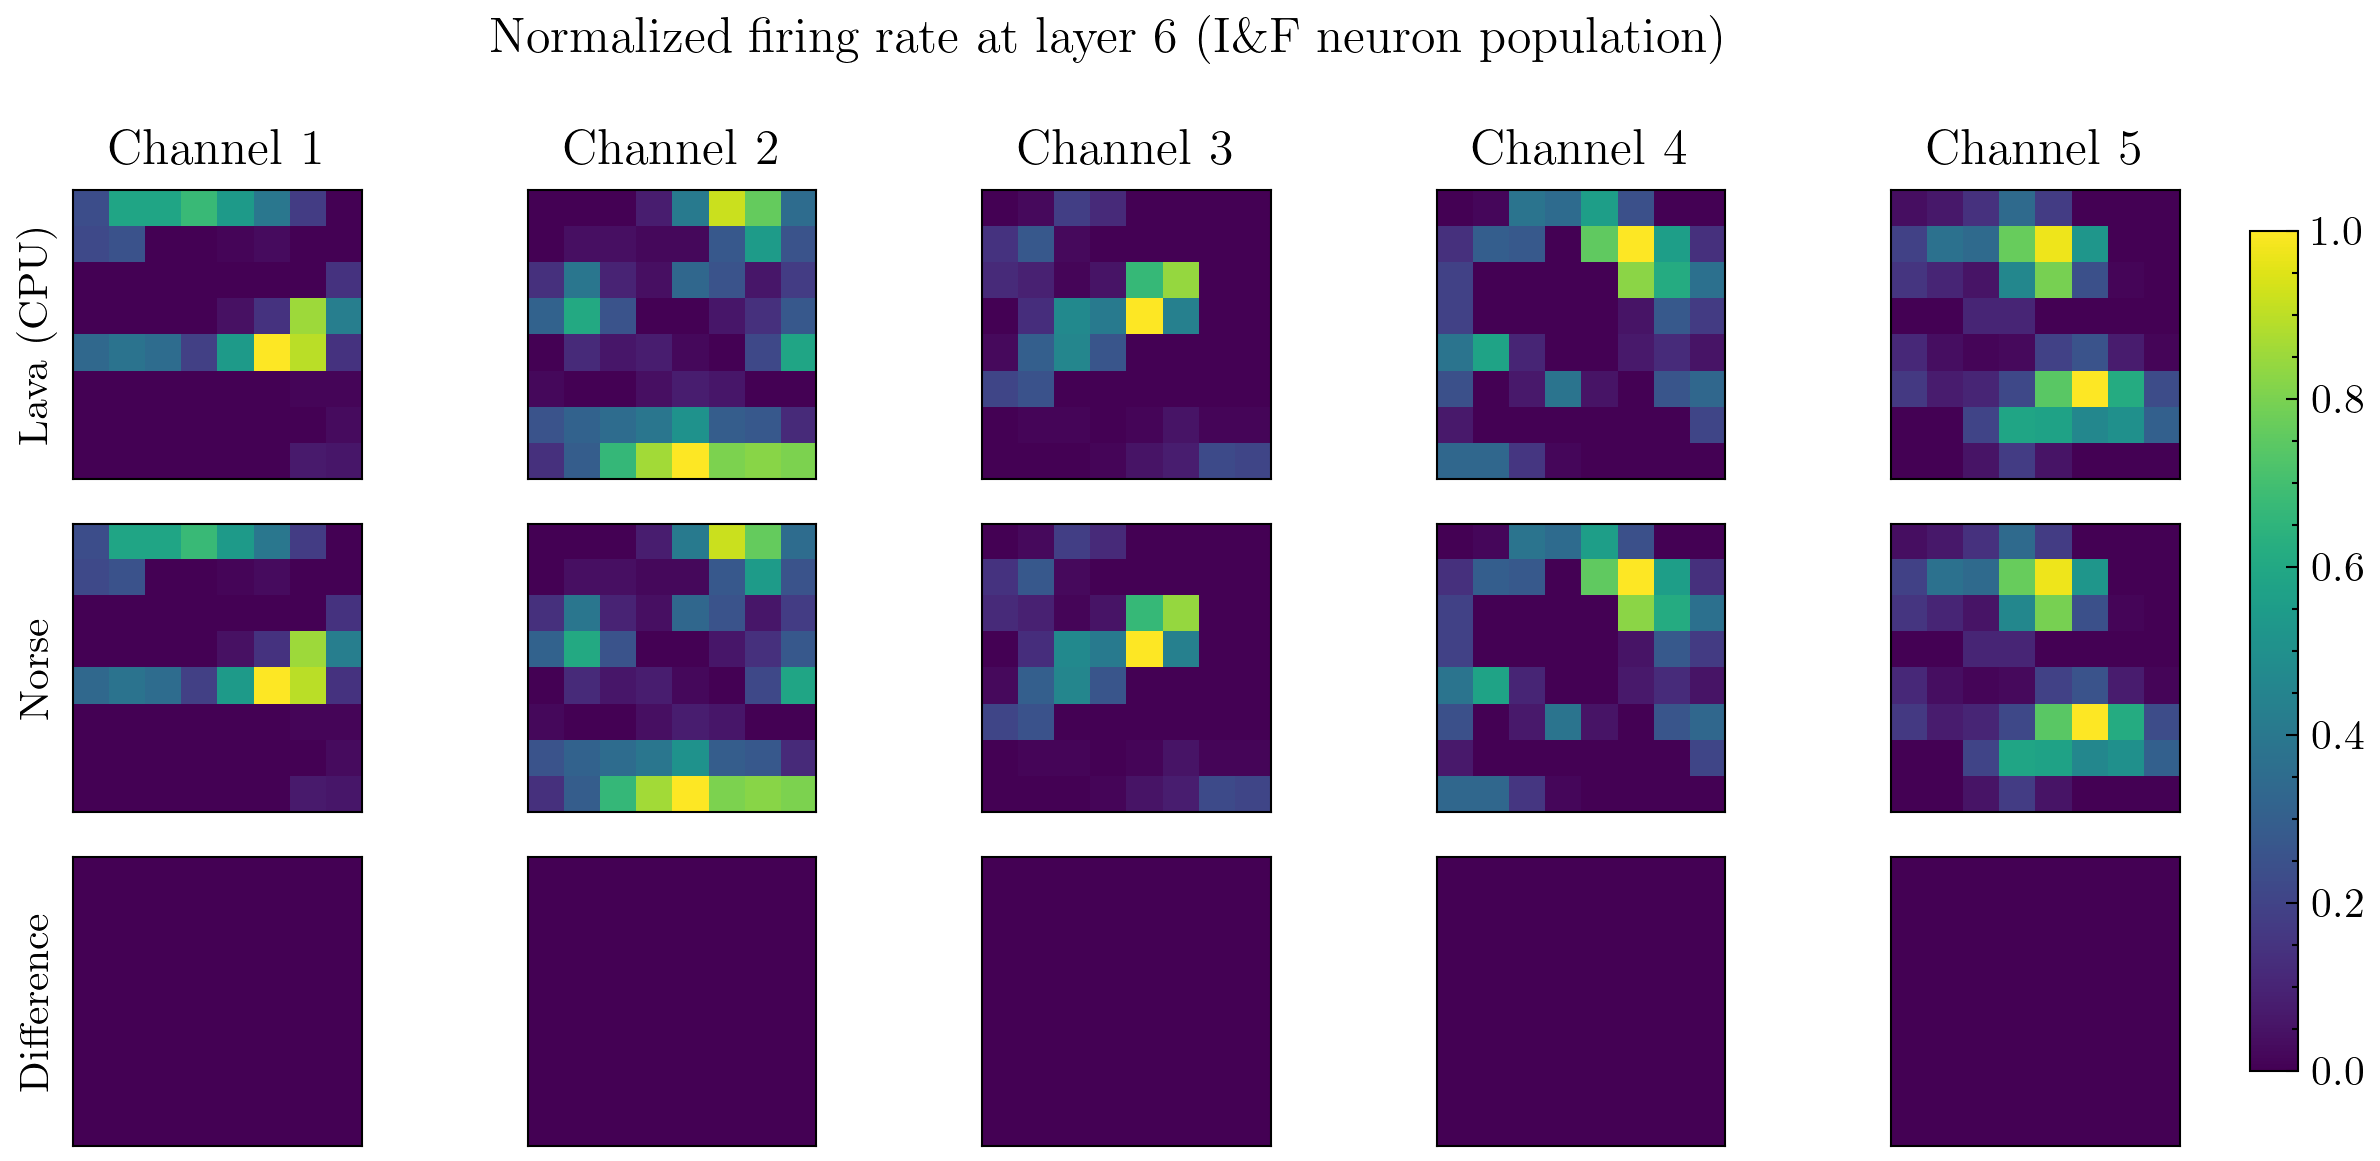

In [154]:
plot_outputs(lava_outputs, norse_outputs, layer_idx=1)
plot_outputs(lava_outputs, norse_outputs, layer_idx=3)
plot_outputs(lava_outputs, norse_outputs, layer_idx=6)